In [1]:
import lightning as L
import torch
from torch import nn

In [2]:
import sys
sys.path.append('/Users/kevinerazocastillo/Desktop/MS_SSL/SSL4MS/')

# Set Up Data Module for Self-Supervised Training

In [3]:
from utils.data_utils import MassSpecSelfSupervisedDataModule

In [4]:
dm = MassSpecSelfSupervisedDataModule(root_dir='/Users/kevinerazocastillo/Desktop/MS_SSL/processed_data/spectra/',
                                     train_csv='/Users/kevinerazocastillo/Desktop/MS_SSL/processed_data/labels/train_labels_split1.csv',
                                     val_csv='/Users/kevinerazocastillo/Desktop/MS_SSL/processed_data/labels/val_labels_split1.csv',
                                     test_csv='/Users/kevinerazocastillo/Desktop/MS_SSL/processed_data/labels/test_labels_split1.csv',
                                     nl_csv='/Users/kevinerazocastillo/Desktop/MS_SSL/SSL4MS/data/neutral_losses.csv',
                                     corrupt_prob=0.1,
                                     max_len=128,
                                     batch_size=64)

# Set Up Model Module

In [5]:
from models.selfsupervised import SpectrumSymmetricAE

In [6]:
spec_AE = SpectrumSymmetricAE(num_heads=4, ffn_factor=4, dropout=0.1, hidden_dims=[8, 32, 128])

In [7]:
print(spec_AE)

SpectrumSymmetricAE(
  (act): Sigmoid()
  (encoder): SpectrumEncoder(
    (act): Sigmoid()
    (enc_list): ModuleList(
      (0): EncoderBlock(
        (act): Sigmoid()
        (cnn): Conv1d(2, 8, kernel_size=(1,), stride=(1,), padding=same)
        (enc): EncoderLayerGLU(
          (act): Sigmoid()
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=8, out_features=8, bias=True)
          )
          (ffn): FFN(
            (fc1): Linear(in_features=8, out_features=32, bias=True)
            (fc2): Linear(in_features=32, out_features=8, bias=True)
            (glu): GLU(
              (act): Sigmoid()
              (linear1): Linear(in_features=32, out_features=32, bias=True)
              (linear2): Linear(in_features=32, out_features=32, bias=True)
            )
          )
          (norm1): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
          (

In [8]:
from torchview import draw_graph

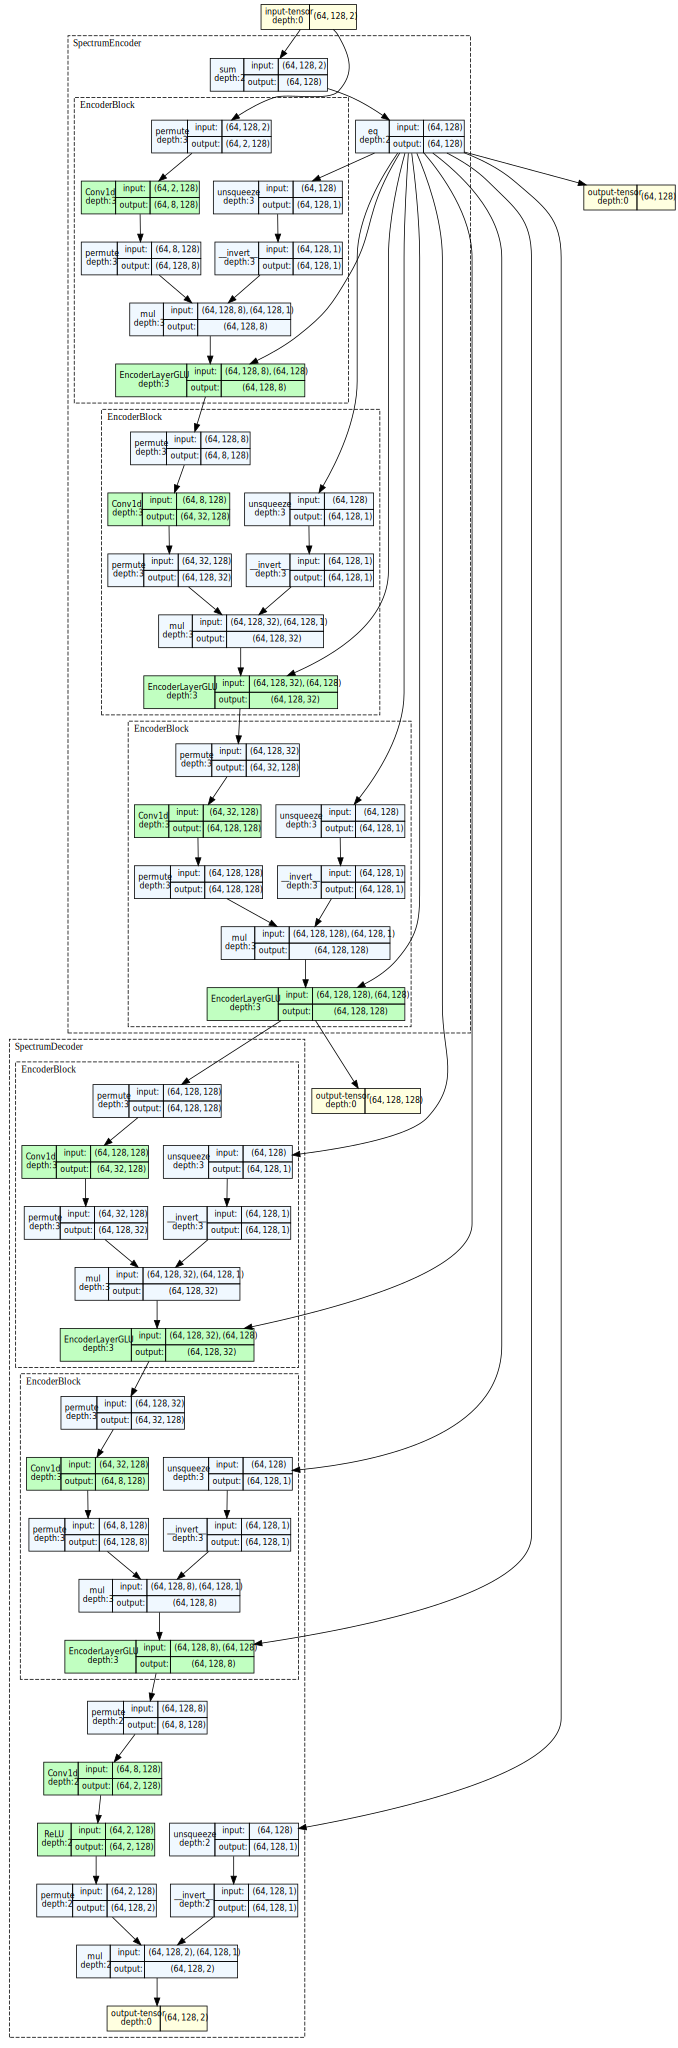

In [9]:
model_graph = draw_graph(spec_AE, input_size=(64,128,2), device='meta', expand_nested=True)
model_graph.visual_graph